In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [6]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

In [7]:
adata.obsm['X_spatial']

array([[ -724.78798784,  -806.77627537],
       [  246.54489078,  1746.15047681],
       [ -117.64861008,  1048.86797915],
       ...,
       [ -636.30278025, -1247.58704544],
       [  661.78246634, -1333.19154819],
       [  812.89596752,  -815.81354621]])

In [8]:
train_Xs = []
train_Ds = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    mask = adata.obs['donor_slice'] == i
    train_Xs.append(np.array(adata.X[mask, :]))
    train_Ds.append(sklearn.metrics.pairwise_distances(adata.obsm['X_spatial'][mask, :]) ** 2)
    
validate_Xs = []
validate_Ds = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    mask = adata.obs['donor_slice'] == i
    validate_Xs.append(np.array(adata.X[mask, :]))
    validate_Ds.append(sklearn.metrics.pairwise_distances(adata.obsm['X_spatial'][mask, :]) ** 2)
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs, Ds):
        super(MyDataSet, self).__init__()
        assert(len(Xs) == len(Ds))
        self.Xs = [torch.Tensor(X) for X in Xs]
        self.Ds = [torch.Tensor(D) for D in Ds]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx], self.Ds[idx]

train_data = MyDataSet(train_Xs, train_Ds)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs, validate_Ds)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [9]:
np.quantile(train_Ds[0].flatten(), .1)

262170.467408073

In [11]:
model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_embed=[512, 256, 128], 
                      d_quality=[512, 256, 1], 
                      n_heads=1,
                      lbd=1.).to('cuda')

In [12]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 200],
                fix=['embed', 'qualify', 'smooth', 'interact'], spatial=True)

G:\kuanglu\examples\..\kuanglu\model.py:227: UserWarning: Some parameters are already fixed. They will be unfixed when exiting this function.
  warnings.warn("Some parameters are already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 3465.821 Validate MSE 1.019 Raw MSE 1.004
Epoch 0002 Train MSE 3465.816 Validate MSE 1.009 Raw MSE 1.003
Epoch 0003 Train MSE 3465.785 Validate MSE 1.027 Raw MSE 1.035
Epoch 0004 Train MSE 3465.770 Validate MSE 0.996 Raw MSE 1.007
Epoch 0005 Train MSE 3465.746 Validate MSE 0.989 Raw MSE 1.016
Epoch 0006 Train MSE 3465.754 Validate MSE 0.943 Raw MSE 0.978
Epoch 0007 Train MSE 3465.724 Validate MSE 0.990 Raw MSE 1.042
Epoch 0008 Train MSE 3465.712 Validate MSE 0.947 Raw MSE 1.002
Epoch 0009 Train MSE 3465.714 Validate MSE 0.944 Raw MSE 1.003
Epoch 0010 Train MSE 3465.712 Validate MSE 0.962 Raw MSE 1.026
Epoch 0011 Train MSE 3465.703 Validate MSE 0.943 Raw MSE 1.010
Epoch 0012 Train MSE 3465.690 Validate MSE 0.937 Raw MSE 1.020
Epoch 0013 Train MSE 3465.689 Validate MSE 0.923 Raw MSE 0.998
Epoch 0014 Train MSE 3465.699 Validate MSE 0.929 Raw MSE 1.005
Epoch 0015 Train MSE 3465.676 Validate MSE 0.939 Raw MSE 1.015
Epoch 0016 Train MSE 3465.668 Validate MSE 0.937 Raw MS

Epoch 0132 Train MSE 3465.640 Validate MSE 0.940 Raw MSE 1.022
Epoch 0133 Train MSE 3465.652 Validate MSE 0.948 Raw MSE 1.038
Epoch 0134 Train MSE 3465.657 Validate MSE 0.904 Raw MSE 0.998
Epoch 0135 Train MSE 3465.660 Validate MSE 0.912 Raw MSE 1.002
Epoch 0136 Train MSE 3465.649 Validate MSE 0.911 Raw MSE 1.008
Epoch 0137 Train MSE 3465.652 Validate MSE 0.921 Raw MSE 1.003
Epoch 0138 Train MSE 3465.639 Validate MSE 0.922 Raw MSE 1.000
Epoch 0139 Train MSE 3465.652 Validate MSE 0.945 Raw MSE 1.024
Epoch 0140 Train MSE 3465.660 Validate MSE 0.958 Raw MSE 1.048
Epoch 0141 Train MSE 3465.651 Validate MSE 0.913 Raw MSE 0.994
Epoch 0142 Train MSE 3465.653 Validate MSE 0.935 Raw MSE 1.035
Epoch 0143 Train MSE 3465.643 Validate MSE 0.930 Raw MSE 1.020
Epoch 0144 Train MSE 3465.645 Validate MSE 0.914 Raw MSE 1.006
Epoch 0145 Train MSE 3465.657 Validate MSE 0.926 Raw MSE 1.002
Epoch 0146 Train MSE 3465.668 Validate MSE 0.911 Raw MSE 0.998
Epoch 0147 Train MSE 3465.646 Validate MSE 0.933 Raw MS

In [14]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [200, 250],
                                           fix=['denoise', 'interact'], spatial=True))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [250, 400],
                                           fix=['interact'], spatial=True))

Epoch 0201 Train MSE 3465.746 Validate MSE 0.969 Raw MSE 1.029
Epoch 0202 Train MSE 3465.720 Validate MSE 0.902 Raw MSE 0.995
Epoch 0203 Train MSE 3465.690 Validate MSE 0.898 Raw MSE 1.004
Epoch 0204 Train MSE 3465.681 Validate MSE 0.902 Raw MSE 1.003
Epoch 0205 Train MSE 3465.669 Validate MSE 0.923 Raw MSE 1.031
Epoch 0206 Train MSE 3465.671 Validate MSE 0.907 Raw MSE 1.007
Epoch 0207 Train MSE 3465.670 Validate MSE 0.898 Raw MSE 1.014
Epoch 0208 Train MSE 3465.654 Validate MSE 0.888 Raw MSE 0.994
Epoch 0209 Train MSE 3465.666 Validate MSE 0.899 Raw MSE 1.001
Epoch 0210 Train MSE 3465.657 Validate MSE 0.914 Raw MSE 1.010
Epoch 0211 Train MSE 3465.664 Validate MSE 0.936 Raw MSE 1.036
Epoch 0212 Train MSE 3465.648 Validate MSE 0.926 Raw MSE 1.036
Epoch 0213 Train MSE 3465.659 Validate MSE 0.905 Raw MSE 1.012
Epoch 0214 Train MSE 3465.658 Validate MSE 0.892 Raw MSE 0.996
Epoch 0215 Train MSE 3465.634 Validate MSE 0.908 Raw MSE 1.015
Epoch 0216 Train MSE 3465.645 Validate MSE 0.894 Raw MS

Epoch 0332 Train MSE 3465.626 Validate MSE 0.841 Raw MSE 0.986
Epoch 0333 Train MSE 3465.615 Validate MSE 0.858 Raw MSE 1.020
Epoch 0334 Train MSE 3465.632 Validate MSE 0.833 Raw MSE 0.982
Epoch 0335 Train MSE 3465.621 Validate MSE 0.830 Raw MSE 1.009
Epoch 0336 Train MSE 3465.617 Validate MSE 0.846 Raw MSE 1.012
Epoch 0337 Train MSE 3465.622 Validate MSE 0.829 Raw MSE 1.000
Epoch 0338 Train MSE 3465.635 Validate MSE 0.794 Raw MSE 0.960
Epoch 0339 Train MSE 3465.638 Validate MSE 0.859 Raw MSE 1.011
Epoch 0340 Train MSE 3465.642 Validate MSE 0.824 Raw MSE 0.993
Epoch 0341 Train MSE 3465.635 Validate MSE 0.863 Raw MSE 1.018
Epoch 0342 Train MSE 3465.631 Validate MSE 0.865 Raw MSE 1.018
Epoch 0343 Train MSE 3465.626 Validate MSE 0.863 Raw MSE 1.014
Epoch 0344 Train MSE 3465.636 Validate MSE 0.842 Raw MSE 0.995
Epoch 0345 Train MSE 3465.608 Validate MSE 0.828 Raw MSE 0.992
Epoch 0346 Train MSE 3465.621 Validate MSE 0.844 Raw MSE 0.997
Epoch 0347 Train MSE 3465.616 Validate MSE 0.823 Raw MS

In [15]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [400, 450],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], spatial=True))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [450, 600], spatial=True))

Epoch 0401 Train MSE 3389.065 Validate MSE 0.868 Raw MSE 1.036
Epoch 0402 Train MSE 3165.685 Validate MSE 0.873 Raw MSE 1.028
Epoch 0403 Train MSE 2953.858 Validate MSE 0.863 Raw MSE 1.015
Epoch 0404 Train MSE 2752.826 Validate MSE 0.852 Raw MSE 1.017
Epoch 0405 Train MSE 2561.997 Validate MSE 0.835 Raw MSE 0.987
Epoch 0406 Train MSE 2381.653 Validate MSE 0.827 Raw MSE 1.010
Epoch 0407 Train MSE 2210.906 Validate MSE 0.872 Raw MSE 1.028
Epoch 0408 Train MSE 2049.485 Validate MSE 0.901 Raw MSE 1.045
Epoch 0409 Train MSE 1896.591 Validate MSE 0.855 Raw MSE 1.012
Epoch 0410 Train MSE 1752.453 Validate MSE 0.881 Raw MSE 1.038
Epoch 0411 Train MSE 1616.912 Validate MSE 0.844 Raw MSE 1.018
Epoch 0412 Train MSE 1489.865 Validate MSE 0.854 Raw MSE 1.016
Epoch 0413 Train MSE 1371.281 Validate MSE 0.846 Raw MSE 1.001
Epoch 0414 Train MSE 1260.056 Validate MSE 0.870 Raw MSE 1.030
Epoch 0415 Train MSE 1156.064 Validate MSE 0.836 Raw MSE 0.998
Epoch 0416 Train MSE 1059.002 Validate MSE 0.840 Raw MS

Epoch 0535 Train MSE 11.160 Validate MSE 0.835 Raw MSE 1.000
Epoch 0536 Train MSE 9.528 Validate MSE 0.846 Raw MSE 1.015
Epoch 0537 Train MSE 8.236 Validate MSE 0.812 Raw MSE 0.961
Epoch 0538 Train MSE 8.577 Validate MSE 0.841 Raw MSE 1.010
Epoch 0539 Train MSE 9.055 Validate MSE 0.849 Raw MSE 1.014
Epoch 0540 Train MSE 9.834 Validate MSE 0.811 Raw MSE 0.981
Epoch 0541 Train MSE 10.543 Validate MSE 0.853 Raw MSE 1.030
Epoch 0542 Train MSE 9.974 Validate MSE 0.837 Raw MSE 0.996
Epoch 0543 Train MSE 8.824 Validate MSE 0.863 Raw MSE 1.022
Epoch 0544 Train MSE 8.770 Validate MSE 0.845 Raw MSE 1.013
Epoch 0545 Train MSE 8.843 Validate MSE 0.836 Raw MSE 0.998
Epoch 0546 Train MSE 9.444 Validate MSE 0.823 Raw MSE 0.984
Epoch 0547 Train MSE 10.857 Validate MSE 0.844 Raw MSE 1.017
Epoch 0548 Train MSE 9.488 Validate MSE 0.848 Raw MSE 1.017
Epoch 0549 Train MSE 8.116 Validate MSE 0.862 Raw MSE 1.028
Epoch 0550 Train MSE 8.412 Validate MSE 0.870 Raw MSE 1.021
Epoch 0551 Train MSE 8.976 Validate M

Text(0, 0.5, 'MSE')

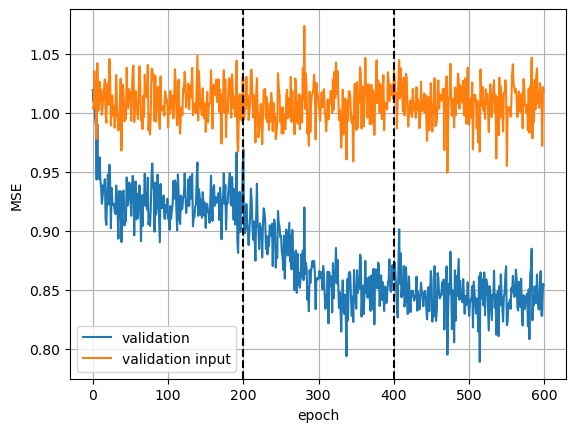

In [16]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
# plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(200, ls='--', c='k')
plt.axvline(400, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [17]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 100: return 'pre-denoise'
    elif x < 200: return 'denoise'
    elif x < 300: return 'pre-denoise-smooth'
    elif x < 400: return 'denoise-smooth'
    elif x < 500: return 'pre-denoise-smooth-enhance'
    elif x < 600: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.019315,pre-denoise
1,1,1.009408,pre-denoise
2,2,1.027366,pre-denoise
3,3,0.995840,pre-denoise
4,4,0.989192,pre-denoise
...,...,...,...
595,595,0.865819,denoise-smooth-enhance
596,596,0.827969,denoise-smooth-enhance
597,597,0.828009,denoise-smooth-enhance
598,598,0.855101,denoise-smooth-enhance


C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


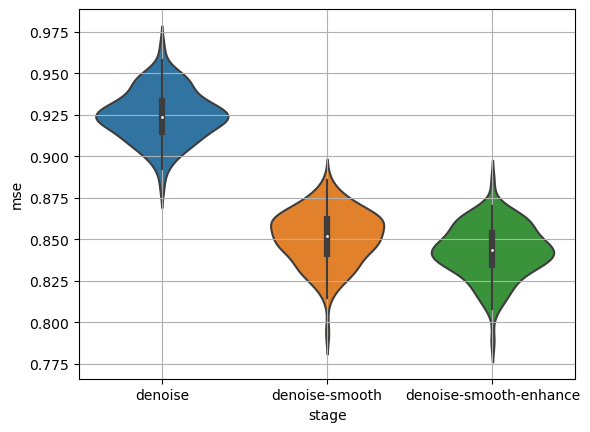

In [18]:
sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.grid()

In [19]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 2.640284031487027e-34 f = 0.9998999999999999


In [20]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 0.00034256160255892036 f = 0.6466


In [ ]:
model.cell_interacts[0].spatial_scale

In [ ]:
model.cell_interacts[1].spatial_scale

In [ ]:
model.cell_interacts[2].spatial_scale